## House Selection and Exploratory Data Analysis

Description : 

This notebook presents the whole dataset available with the name of `EWHDataset.csv`. A plot displays the mean and the standard deviation for the hourly hot water consumption on all houses without missing values. 

After more detailled analyses are performed on the selected house such as a daily box-plot, a hourly box-plot and an auto-correlation plot. The last line can be uncommented in order to save the figures.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
AXES = 14
LEGEND = 22
TICK = 12

plt.rc('axes', titlesize=AXES)     # fontsize of the axes title
plt.rc('axes', labelsize=AXES)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICK)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICK)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND)    # legend fontsize

### Pre-processing

In [89]:
df = pd.read_csv('EWHDataset.csv', header=0, infer_datetime_format=True, parse_dates=['time'], index_col=['time'])

In [90]:
mean_EHW = df.agg('mean',axis=1)
df['mean_EHW'] = mean_EHW

#### Remove houses with missing values

In [91]:
np.argwhere(df.isnull().any())

C:\Users\nilso\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


array([[17],
       [38],
       [50],
       [70]], dtype=int64)

In [92]:
df = df.drop(columns=['18','39','51','71'])

#### Include weekday and hour

In [93]:
df['weekday'] = df.index.dayofweek
df['hour'] = df.index.hour

In [94]:
households = [str(x) for x in range(1,99) if x not in (18,39,51,71)]
cols = ['weekday','hour','mean_EHW']+ households

df = df.reindex(columns=cols)

### Aggregated Data Analysis

Look at the aggregated values, meaning the mean consumption across all houses

#### Average consumption per hour 

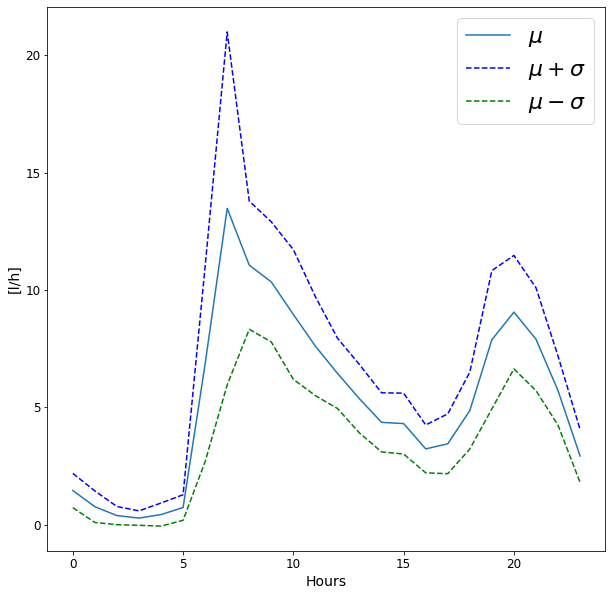

In [95]:
mean_hourly = df.groupby('hour').agg({'mean_EHW':'mean'})
std_hourly = df.groupby('hour').agg({'mean_EHW':'std'})

fig,ax = plt.subplots(figsize=(10,10))
ax.plot(mean_hourly,label='$\mu$')
ax.plot(mean_hourly+std_hourly,'--',color='blue',label='$\mu + \sigma$')
ax.plot(mean_hourly-std_hourly,'--',color = 'green',label='$\mu - \sigma$')

plt.ylabel('[l/h]')
plt.xlabel('Hours')
plt.legend()
#plt.savefig('Figure_2_a.png', dpi=1200,bbox_inches = 'tight')

Text(0.5, 0, 'Hours')

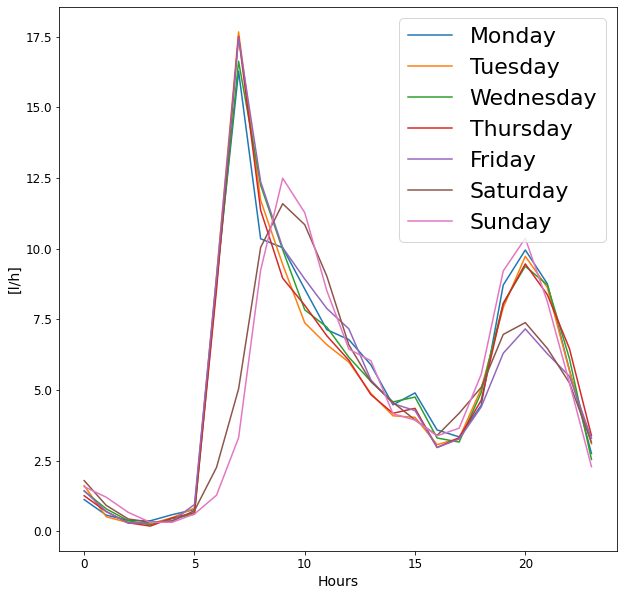

In [96]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(df.groupby([df.index.dayofweek,'hour']).agg({'mean_EHW':'mean'}).unstack(0).values[:,0],label='Monday')
ax.plot(df.groupby([df.index.dayofweek,'hour']).agg({'mean_EHW':'mean'}).unstack(0).values[:,1],label='Tuesday')
ax.plot(df.groupby([df.index.dayofweek,'hour']).agg({'mean_EHW':'mean'}).unstack(0).values[:,2],label='Wednesday')
ax.plot(df.groupby([df.index.dayofweek,'hour']).agg({'mean_EHW':'mean'}).unstack(0).values[:,3],label='Thursday')
ax.plot(df.groupby([df.index.dayofweek,'hour']).agg({'mean_EHW':'mean'}).unstack(0).values[:,4],label='Friday')
ax.plot(df.groupby([df.index.dayofweek,'hour']).agg({'mean_EHW':'mean'}).unstack(0).values[:,5],label='Saturday')
ax.plot(df.groupby([df.index.dayofweek,'hour']).agg({'mean_EHW':'mean'}).unstack(0).values[:,6],label='Sunday')

plt.legend(loc='upper right')
plt.ylabel('[l/h]')
plt.xlabel('Hours')
#plt.savefig("Figure_2_b.png", dpi=1200,bbox_inches = 'tight')

In [97]:
day = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

grouped_df = df.groupby(['weekday','hour']).mean()

mean_EHW = grouped_df[households].agg(axis=1,func='mean')
std_EHW = grouped_df[households].agg(axis=1,func='std')

mean_EHW = mean_EHW.to_frame()

mean_EHW = mean_EHW.rename({0:'mean_over_houses'},axis=1)

In [98]:
daily_mean = []

for i in range(7):
    
    daily_mean.append(mean_EHW['mean_over_houses'].values[i*24:i*24+24])
    
daily_mean = np.array(daily_mean)

daily_mean = pd.DataFrame(daily_mean.T,
                          columns=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

corr = daily_mean.corr()

### Correlation of mean hourly consumption within days

In [99]:
from matplotlib import ticker, cm

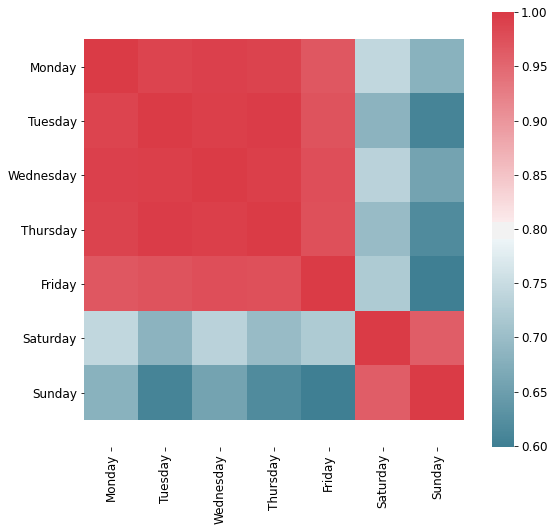

In [100]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

#f.savefig('Figure_3.png',dpi=1200,bbox_inches='tight')

In [102]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [104]:
df.index = pd.to_datetime(df.index)

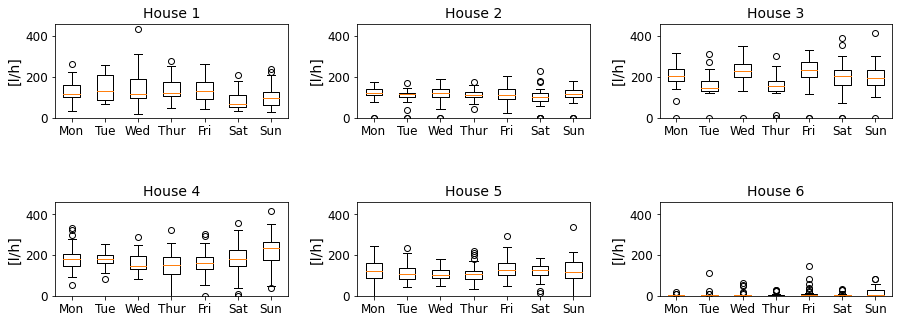

In [107]:
import matplotlib.dates as mdates

fig, axs = plt.subplots(2,3,figsize=(15,5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.9)
axs = axs.flatten()

for x, house in enumerate(['6','40','59','72','87','60']):
    
    data = []
    df_house = df[house].resample('D').sum()
    for i in range(7) :
        data.append(df_house.loc[df_house.index.weekday == i].values)
    
    axs[x].boxplot(data)
    axs[x].set_title(f'House {x+1}',fontsize=14)
    axs[x].set_ylabel('[l/h]',fontsize=14)
    axs[x].set_xticks(range(1,8))
    axs[x].set_xticklabels(['Mon','Tue','Wed','Thur','Fri','Sat','Sun'])
    axs[x].set_ylim(0,460)
    #axs[x].set_ylim([0,np.max(df.loc['2018-01-15':'2018-01-20',house])+5])

#plt.savefig('Figure_4_a.png',dpi=1200,bbox_inches='tight')

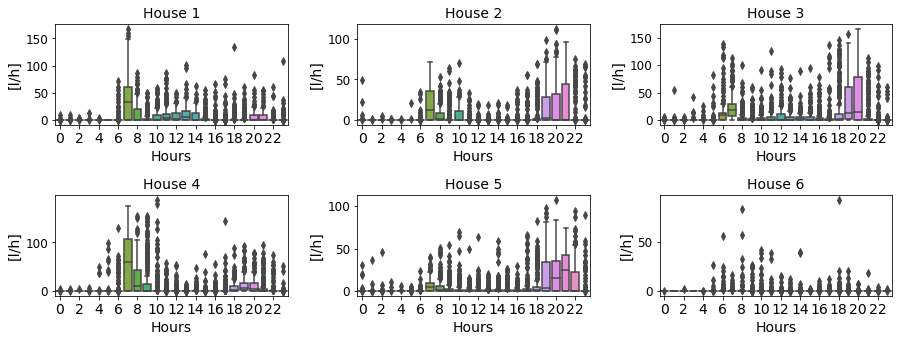

In [106]:
fig, axs = plt.subplots(2,3,figsize=(15,5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.7)
axs = axs.flatten()

for x, house in enumerate(['6','40','59','72','87','60']):

    sns.boxplot(data=df,y=df[house],x=df['hour'], ax = axs[x])
    axs[x].set_xticks(np.arange(0,23, 2))
    axs[x].set_xticklabels(np.arange(0,23,2),fontsize=14)
    axs[x].tick_params(rotation=0)
    axs[x].set_ylabel('[l/h]',fontsize=14)
    axs[x].set_xlabel('Hours',fontsize=14)
    axs[x].set_title(f'House {x+1}',fontsize=14)
    
#fig.savefig('Figure_4_a.png',dpi=1200,bbox_inches='tight')

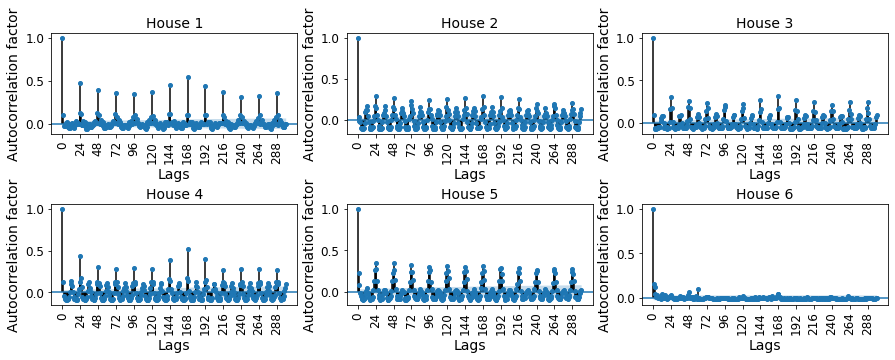

In [105]:
fig, axs = plt.subplots(2,3,figsize=(15,5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.7)
axs = axs.flatten()

for x, house in enumerate(['6','40','59','72','87','60']):
    
    plot_acf(df[house],ax=axs[x],lags=300,markersize=4)
    axs[x].set_xticks(np.arange(0,300, 24))
    axs[x].set_xticklabels(np.arange(0,300, 24),rotation=90)
    axs[x].set_title(f'House {x+1}',fontsize=14)
    axs[x].set_xlabel('Lags',fontsize=14)
    axs[x].set_ylabel('Autocorrelation factor',fontsize=14)

    
#fig.savefig('Figure_5.png',dpi=1200,bbox_inches='tight')